In [13]:
%matplotlib inline

In [2]:
import itertools
import torch 
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix

## 1. Loading the data

PyTorch has [dataset class](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html) for MNIST (of course it does!)

Notice that the `ToTensor` transform already normalizes the images to the interval \[0,1\]

In [3]:
train_dataset = datasets.MNIST('../data', transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())

In [4]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

## 2. Bulding the model

I'm going to make some interesting observations here:

* Based on the examples I've seen so far, I've noticed that it's very common in PyTorch that the last layer of classification network is **not followed by softmax**. This happens because the `nn.CrossEntropyLoss` computes the softmax internally. In test time, if you don't care about the actual probabilities, you just have to do an argmax to get the predictions. If you do care, you can compute the softmax outside the model or even use the `self.training` flag to modify the model behaviour during test time.


* There are some options regarding where to put things like relu, dropout and max pooling. You can define them as layers in the `__init__` method (just like I did with dropout), or use the functional API (as I did with relu and max pool). Both options are identical, and it's just a matter of personal taste, although I was convinced at [this discussion](https://discuss.pytorch.org/t/how-to-choose-between-torch-nn-functional-and-torch-nn-module/2800/16) that a good strategy is to build layers when there are trainable parameters and use the functional API otherwise. I choose to use dropout as a layer because it is stateful in some sense, it has different train/test behaviour. In order to use dropout on the functional API, you have to explicity pass the self.training flag as an argument:

        x = F.dropout(x, training=self.training)
        
Another option is to use `nn.Sequential` to make the model more compact, as a friend of mine did in this [GAN notebook](https://github.com/prcastro/pytorch-gan/blob/master/MNIST%20GAN.ipynb).

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.drop1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64*5*5, 128)
        self.drop2 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64*5*5)
        x = self.drop1(x)
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = self.fc2(x)
        return x        

In [6]:
model = CNN()
model.cuda()

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop1): Dropout(p=0.5)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (drop2): Dropout(p=0.25)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## 3. Loss function and optimizer

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## 4. Training Loop

In [8]:
hist = {'loss': [], 'val_loss': [], 'val_acc': []}
num_epochs = 5
for epoch in range(num_epochs):
    print('Starting epoch {}/{}'.format(epoch+1, num_epochs))
    # train
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
    
    train_loss = running_loss / len(train_loader)
    
    # evalute
    model.eval()
    val_running_loss = 0.0
    correct = 0
    for images, labels in test_loader:
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        val_running_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels.data).sum()
    
    
    val_loss = val_running_loss / len(test_loader)
    val_acc = correct / len(test_dataset)
    
    hist['loss'].append(train_loss)
    hist['val_loss'].append(val_loss)
    hist['val_acc'].append(val_acc)
    
    print('loss: {:.4f}  val_loss: {:.4f} val_acc: {:4.4f}\n'.format(train_loss, val_loss, val_acc))      
    
    

Starting epoch 1/5
loss: 0.2096  val_loss: 0.0485 val_acc: 0.9840

Starting epoch 2/5
loss: 0.0856  val_loss: 0.0358 val_acc: 0.9868

Starting epoch 3/5
loss: 0.0659  val_loss: 0.0333 val_acc: 0.9881

Starting epoch 4/5
loss: 0.0548  val_loss: 0.0254 val_acc: 0.9910

Starting epoch 5/5
loss: 0.0473  val_loss: 0.0258 val_acc: 0.9910



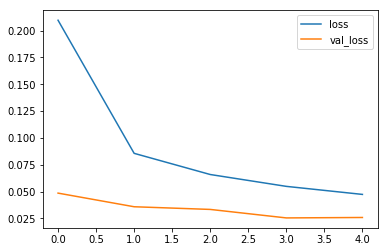

In [9]:
pd.DataFrame(hist)[['loss', 'val_loss']].plot()

## 5. Confusion matrix

I'll make this by hand, but next time I might use [PyTorchNet](https://github.com/pytorch/tnt).

In [10]:
model.eval()
y_test = []
y_pred = []
for images, labels in test_loader:
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())
    
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[ 975    0    0    0    0    0    2    1    2    0]
 [   0 1125    2    0    0    1    1    0    6    0]
 [   1    0 1026    0    0    0    1    3    1    0]
 [   0    0    2 1005    0    1    0    1    1    0]
 [   0    0    0    0  967    0    3    0    5    7]
 [   1    0    0    7    0  882    1    0    0    1]
 [   3    2    0    0    1    1  951    0    0    0]
 [   0    1    6    0    0    0    0 1018    1    2]
 [   0    0    1    1    0    0    0    0  971    1]
 [   2    0    0    1    2    6    0    2    6  990]]


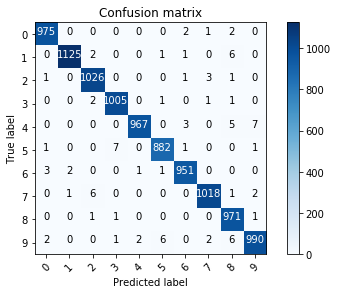

In [12]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=list(range(10)))